In [1]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [2]:
path2 = r'C:\Users\ritam\OneDrive\Documents\The sparks foundation files\Stock market prediction\india-news-headlines.csv'
ndf = pd.read_csv(path2, header=None, names=['Date', 'Category', 'News'])

In [3]:
ndf.head(5)

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [4]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3650961,20220331,Garment industry jittery over'GST hike'
3650962,20220331,AAP MLAs interfering in work: Councillors
3650963,20220331,Schools organise vax camps for kids
3650964,20220331,Madhya Pradesh CM Shivraj Singh Chouhan promis...


In [6]:
path1 = r'C:\Users\ritam\OneDrive\Documents\The sparks foundation files\Stock market prediction\Nifty50-19sep22-18sep23.csv'

# Load the second dataset
hisdf =pd.read_csv(path1)
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,19-09-2022,17540.65039,17667.19922,17429.69922,17622.25000,258300,17622.25000
1,20-09-2022,17770.40039,17919.30078,17744.40039,17816.25000,263100,17816.25000
2,21-09-2022,17766.34961,17838.69922,17663.59961,17718.34961,245500,17718.34961
3,22-09-2022,17609.65039,17722.75000,17532.44922,17629.80078,284100,17629.80078
4,23-09-2022,17593.84961,17642.15039,17291.65039,17327.34961,390800,17327.34961
...,...,...,...,...,...,...,...
239,05-09-2023,19564.65039,19587.05078,19525.75000,19574.90039,256800,19574.90039
240,06-09-2023,19581.19922,19636.44922,19491.50000,19611.05078,287600,19611.05078
241,07-09-2023,19598.65039,19737.00000,19550.05078,19727.05078,304900,19727.05078
242,08-09-2023,19774.80078,19867.15039,19727.05078,19819.94922,288100,19819.94922


In [7]:
# Check for common information of the first datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [9]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [11]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

In [13]:
len(ndf)

7717

In [14]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,19-09-2022,17540.65039,17667.19922,17429.69922,17622.25000,258300
1,20-09-2022,17770.40039,17919.30078,17744.40039,17816.25000,263100
2,21-09-2022,17766.34961,17838.69922,17663.59961,17718.34961,245500
3,22-09-2022,17609.65039,17722.75000,17532.44922,17629.80078,284100
4,23-09-2022,17593.84961,17642.15039,17291.65039,17327.34961,390800
...,...,...,...,...,...,...
239,05-09-2023,19564.65039,19587.05078,19525.75000,19574.90039,256800
240,06-09-2023,19581.19922,19636.44922,19491.50000,19611.05078,287600
241,07-09-2023,19598.65039,19737.00000,19550.05078,19727.05078,304900
242,08-09-2023,19774.80078,19867.15039,19727.05078,19819.94922,288100


In [15]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    249 non-null    datetime64[ns]
 1   Open    249 non-null    float64       
 2   High    249 non-null    float64       
 3   Low     249 non-null    float64       
 4   Close   249 non-null    float64       
 5   Volume  249 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 11.8 KB


In [16]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,249.000000,249.000000,249.000000,249.000000,249.000000
mean,18327.734155,18393.458373,18233.147151,18316.258691,262222.489960
std,822.954687,815.664728,835.739009,831.165004,75761.676255
min,16798.050780,17026.050780,16747.699220,16818.099610,0.000000
25%,17756.400390,17799.949220,17612.500000,17718.349610,222500.000000
50%,18201.099610,18262.300780,18100.300780,18191.000000,252700.000000
75%,18752.400390,18839.699220,18710.500000,18771.250000,283300.000000
max,20156.449220,20222.449220,20129.699220,20192.349610,696500.000000


In [17]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [18]:
len(hisdf)

249

Text(0, 0.5, 'Nifty 50')

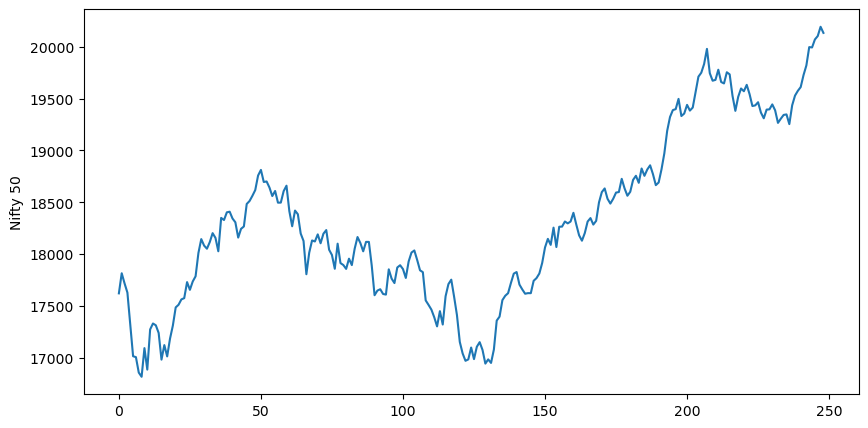

In [19]:
# Figure plot
plt.figure(figsize=(10,5))
hisdf['Close'].plot()
plt.ylabel('Nifty 50')

In [20]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

## Historical Analysis

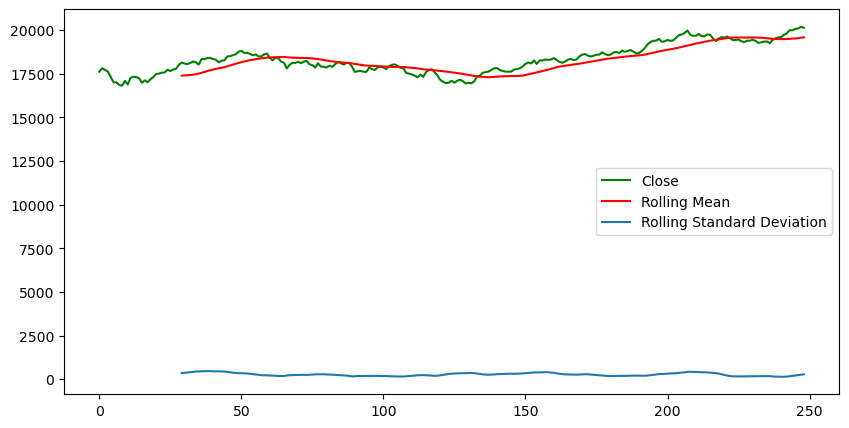

In [21]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 30).mean()
std = close.rolling(window = 30).std()

plt.figure(figsize=(10,5))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

## Plotting returns

Text(0.5, 1.0, 'Returns')

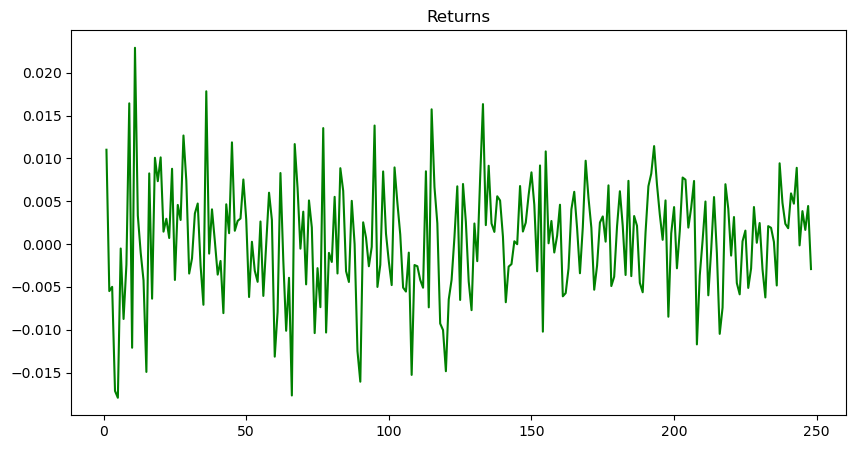

In [22]:
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,5))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [23]:
# Train test split
train = hisdf[:234]
test = hisdf[234:]

# Rolling mean and Standard Deviation

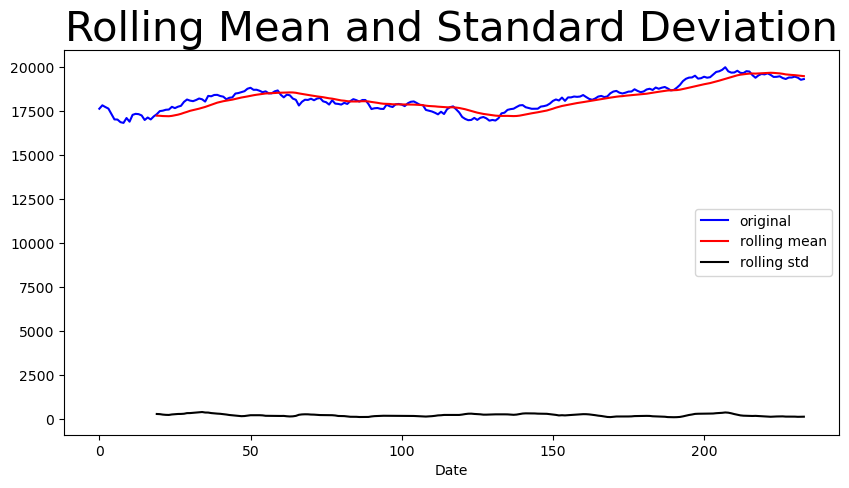

Results of dickey fuller test
ADF Test Statistic : -0.9208747098142062
p-value : 0.7810203745192832
#Lags Used : 0
Number of Observations Used : 233
Weak evidence against null hypothesis, time series is non-stationary 


In [24]:
from statsmodels.tsa.stattools import adfuller

#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,5))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

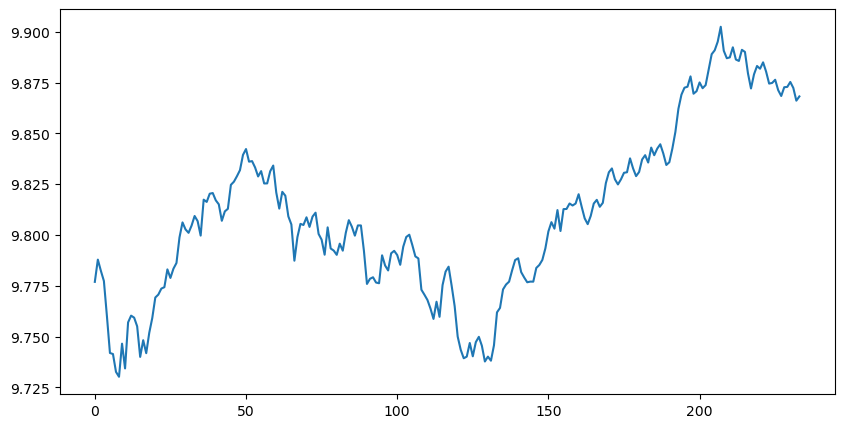

In [25]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (10,5))
plt.plot(train_log)

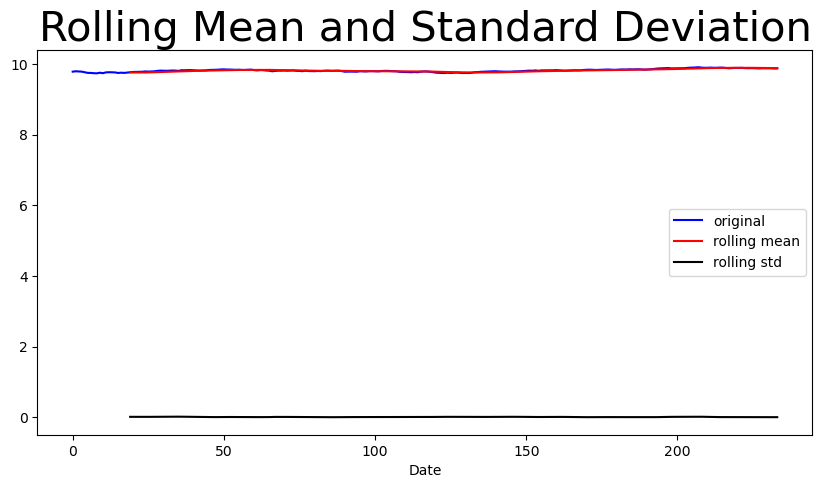

Results of dickey fuller test
ADF Test Statistic : -0.9582548703506824
p-value : 0.7681838949793329
#Lags Used : 0
Number of Observations Used : 233
Weak evidence against null hypothesis, time series is non-stationary 


In [26]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

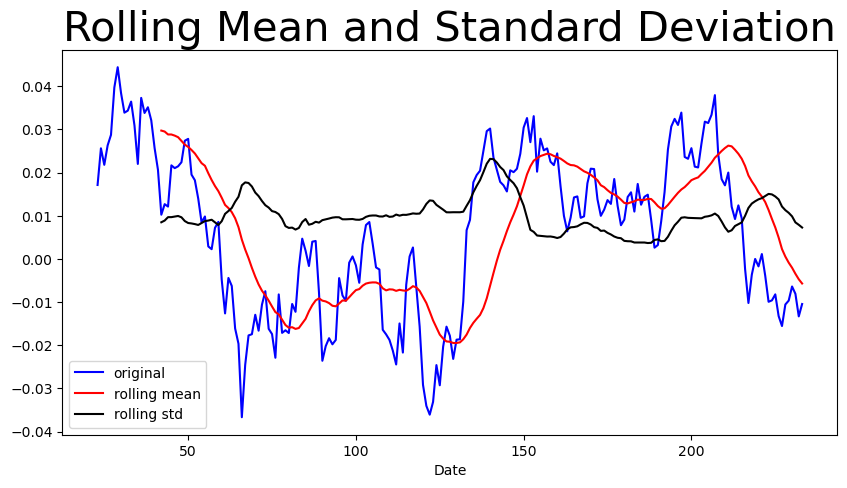

Results of dickey fuller test
ADF Test Statistic : -2.578366101232163
p-value : 0.09755149518235179
#Lags Used : 1
Number of Observations Used : 209
Weak evidence against null hypothesis, time series is non-stationary 


In [27]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [28]:
pip install pmdarima

     -------------------------------------- 572.7/572.7 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima

In [34]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1655.485, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1663.969, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1662.556, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1662.480, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1665.186, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1660.904, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.569 seconds


plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('NIFTY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [36]:
test_log.fillna(test_log.mean(), inplace=True)
predictions.fillna(predictions.mean(), inplace=True)

test_log.dropna(inplace=True)
predictions.dropna(inplace=True)

In [37]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.027275343987382093


# Textual Analysis 

In [38]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [39]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)

In [41]:
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [42]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ritam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [45]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]

In [53]:
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,-0.9999,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,-0.9999,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,-0.9999,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,-0.9999,0.156,0.769,0.076


# Merge the Historical and Textual Data

In [85]:
df_merge = pd.merge(hisdf, ndf, how='inner', on='Date')

In [93]:
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2022-03-10,17102.09961,17114.65039,16855.55078,16887.34961,278400,Writers are the new heroes Karan Vyas The dou...,0.400017,0.053332,-0.9999,0.138,0.777,0.085
1,2022-01-11,18130.69922,18175.80078,18060.15039,18145.40039,349900,Vaikuntha Ekadashi Check date time si...,0.388525,0.071044,-0.9998,0.147,0.749,0.104
2,2022-02-11,18177.90039,18178.75000,18048.65039,18082.84961,270900,Chaithra Kotoor took cues from a real cop to p...,0.353223,0.043691,-0.9999,0.152,0.751,0.098
3,2022-03-11,17968.34961,18106.30078,17959.19922,18052.69922,213000,Powerism A song tribute to Puneeth on his bir...,0.381354,0.071642,-0.9997,0.147,0.750,0.103
4,2022-01-12,18871.94922,18887.59961,18778.19922,18812.50000,325000,Makar Sankranti Check date rituals and ...,0.389878,0.041324,-0.9999,0.160,0.742,0.098
5,2022-02-12,18752.40039,18781.94922,18639.19922,18696.09961,254400,How Rishabh Shetty raced buffaloes through slu...,0.342285,0.043845,-0.9999,0.171,0.744,0.085


# Create Dataset for Model Training

In [95]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,16887.34961,0.400017,0.053332,-0.9999,0.138,0.777,0.085
1,18145.40039,0.388525,0.071044,-0.9998,0.147,0.749,0.104
2,18082.84961,0.353223,0.043691,-0.9999,0.152,0.751,0.098
3,18052.69922,0.381354,0.071642,-0.9997,0.147,0.750,0.103
4,18812.50000,0.389878,0.041324,-0.9999,0.160,0.742,0.098
5,18696.09961,0.342285,0.043845,-0.9999,0.171,0.744,0.085


# Normalize Data

In [61]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.000000,1.000000,0.396050,0.0,0.000000,1.000000,0.000000
1,0.653482,0.800942,0.980250,0.5,0.272727,0.200000,1.000000
2,0.620990,0.189469,0.078067,0.0,0.424242,0.257143,0.684211
3,0.605329,0.676740,1.000000,1.0,0.272727,0.228571,0.947368
4,1.000000,0.824372,0.000000,0.0,0.666667,0.000000,0.684211


In [62]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,1.000000,0.396050,0.0,0.000000,1.000000,0.000000
1,0.800942,0.980250,0.5,0.272727,0.200000,1.000000
2,0.189469,0.078067,0.0,0.424242,0.257143,0.684211
3,0.676740,1.000000,1.0,0.272727,0.228571,0.947368
4,0.824372,0.000000,0.0,0.666667,0.000000,0.684211
5,0.000000,0.083134,0.0,1.000000,0.057143,0.000000


In [63]:
Y=df['Close']
Y

0    0.000000
1    0.653482
2    0.620990
3    0.605329
4    1.000000
5    0.939537
Name: Close, dtype: float64

# Split the Dataset into Train & Test Data

In [82]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 0)
x_train.shape

(5, 6)

In [84]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
2,0.189469,0.078067,0.0,0.424242,0.257143,0.684211
1,0.800942,0.980250,0.5,0.272727,0.200000,1.000000
3,0.676740,1.000000,1.0,0.272727,0.228571,0.947368
0,1.000000,0.396050,0.0,0.000000,1.000000,0.000000
4,0.824372,0.000000,0.0,0.666667,0.000000,0.684211


# RandomForestRegressor Model

In [96]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [97]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.61377527]
5    0.939537
Name: Close, dtype: float64
Mean Squared error:  0.10612069516979769


# DecisionTreeRegressor Model

In [99]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [100]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[1.]
5    0.939537
Name: Close, dtype: float64
Mean Squared error:  0.003655775748983228


# AdaBoostRegressor Model

In [101]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [102]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.10147189956429506


# LGBMRegressor Model

In [104]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] Start training from score 0.575960
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

LGBMRegressor()

In [105]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.1321880154421832


# XGBRegressor Model

In [106]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [107]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.1012891329379229
